<a href="https://colab.research.google.com/github/AlmaBasic/Artificial-intelligence/blob/main/Vjezba_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%capture
#!pip install torch torchvision -U
#!pip install librosa matplotlib

In [18]:
import torch

print(torch.__version__)

2.6.0+cu124


Importovanje biblioteka

In [1]:
import os, wave, librosa, numpy as np, pandas as pd
from tqdm import tqdm
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt

Povezivanje sa Google driveom i pregled direktorija

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/MyDrive/train/audio"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
_background_noise_  dog    four   left	  off	 seven	 three	wow
bed		    down   go	  marvin  on	 sheila  tree	yes
bird		    eight  happy  nine	  one	 six	 two	zero
cat		    five   house  no	  right  stop	 up


In [3]:
path = "/content/drive/MyDrive/train/audio"
classes = os.listdir(path)

Priprema liste fajlova

In [4]:
classes.remove('_background_noise_')
data, classes_, filename, duration_length = [], [], [], []

Čitanje fajlova i računanje njihove dužine

In [5]:
for class_ in classes:
    class_files = os.listdir(os.path.join(path, class_))
    for file_name in class_files:
        full_filename = os.path.join(path, class_, file_name)
        filename.append(full_filename)

        y, sr = librosa.load(full_filename, sr=16000)
        duration = librosa.get_duration(y=y, sr=sr)
        classes_.append(class_)
        duration_length.append(duration)

In [6]:
filename[:10]

['/content/drive/MyDrive/train/audio/bed/1365dd89_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/97e0c576_nohash_2.wav',
 '/content/drive/MyDrive/train/audio/bed/ac652c60_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/23ad12d8_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/161fcca8_nohash_1.wav',
 '/content/drive/MyDrive/train/audio/bed/a19452d5_nohash_1.wav',
 '/content/drive/MyDrive/train/audio/bed/b72e58c9_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/e3411931_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/1528225c_nohash_3.wav',
 '/content/drive/MyDrive/train/audio/bed/1706c35f_nohash_3.wav']

Kreiramo dataframe

In [7]:
df = pd.DataFrame({'Filename': filename, 'Class': classes_, 'Duration': duration_length})
df.to_csv('/content/drive/MyDrive/train/data.csv')

In [26]:
df.head()

,Unnamed: 0,Filename,Class,Duration,LabelID
0,0,/content/drive/MyDrive/train/audio/bed/1365dd8...,bed,1.0,0
1,1,/content/drive/MyDrive/train/audio/bed/97e0c57...,bed,1.0,0
2,2,/content/drive/MyDrive/train/audio/bed/ac652c6...,bed,1.0,0
3,3,/content/drive/MyDrive/train/audio/bed/23ad12d...,bed,1.0,0
4,4,/content/drive/MyDrive/train/audio/bed/161fcca...,bed,1.0,0


In [9]:
df.shape

(63258, 3)

In [10]:
df['Class'].value_counts()

,count
Class,
stop,2380
seven,2377
yes,2377
zero,2376
no,2375
up,2375
off,2374
two,2373
go,2372


Vizualizacija spektrograma

In [27]:
df = pd.read_csv('/content/drive/MyDrive/train/data.csv')  # ako već nije učitano
audio_path = df['Filename'].iloc[0]  # uzimaš prvi fajl

In [28]:
y, sr = librosa.load(audio_path)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

Kreiranje mel-spektrograma

In [29]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

Pravljenje dataseta

In [30]:
from torch.utils.data import Dataset
import librosa
import torchaudio

class AudioDataset(Dataset):
    def __init__(self, csv_file, sr=16000, duration=1):
        self.data = pd.read_csv(csv_file)
        self.sr = sr                    # Sample rate (npr. 16kHz)
        self.duration = duration        # Dužina trajanja u sekundama
        self.input_length = sr * duration  # Ukupan broj uzoraka

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      path = self.data.iloc[idx]['Filename']
      label = self.data.iloc[idx]['LabelID']

      # Učitavanje audio fajla
      y, sr = librosa.load(path, sr=self.sr)

      # Padding ili skraćivanje da svi audiji budu iste dužine
      if len(y) < self.input_length:
          y = np.pad(y, (0, self.input_length - len(y)))
      else:
          y = y[:self.input_length]

      # Pretvori u torch.Tensor
      y = torch.tensor(y).unsqueeze(0)  # (1, num_samples)

      # Mel-spektrogram
      mel_transform = torchaudio.transforms.MelSpectrogram(
          sample_rate=self.sr,
          n_fft=1024,
          hop_length=512,
          n_mels=64
      )
      mel = mel_transform(y)  # (1, n_mels, time)

      # Pretvori u dB skalu (opcionalno)
      db_transform = torchaudio.transforms.AmplitudeToDB()
      mel_db = db_transform(mel)

      # Normalizacija
      mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)

      return mel_db, int(label)


Kreiranje CNN modela

In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # Projekcije za skip konekcije (ako je broj kanala različit)
        self.skip1 = nn.Conv2d(16, 32, kernel_size=1)  # za spajanje conv1 -> conv2
        self.skip2 = nn.Conv2d(32, 64, kernel_size=1)  # za spajanje conv2 -> conv3

        # Dummy input za izračunavanje veličine
        dummy_input = torch.zeros(1, 1, 64, 32)
        dummy_out = self._forward_features(dummy_input)
        self.flattened_size = dummy_out.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_features(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))  # [B, 16, H, W]

        x2 = self.pool(F.relu(self.conv2(x1)))  # [B, 32, H/2, W/2]
        skip1 = self.pool(self.skip1(x1))       # prilagodi dimenzije za sabiranje
        x2 = x2 + skip1                         # SKIP CONNECTION

        x3 = self.pool(F.relu(self.conv3(x2)))  # [B, 64, H/4, W/4]
        skip2 = self.pool(self.skip2(x2))       # prilagodi dimenzije za sabiranje
        x3 = x3 + skip2                         # SKIP CONNECTION

        return x3

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [32]:
# Učitaj CSV koji sadrži klasne nazive
df = pd.read_csv('/content/drive/MyDrive/train/data.csv')

# Kreiraj label2id mapu (npr. 'yes' -> 0, 'no' -> 1, itd.)
labels = sorted(df['Class'].unique())
label2id = {label: idx for idx, label in enumerate(labels)}

# Dodaj novu kolonu s numeričkim ID-jem klase
df['LabelID'] = df['Class'].map(label2id)

# Spasi kao novi CSV
df[['Filename', 'LabelID']].to_csv('/content/drive/MyDrive/train/data_labels.csv', index=False)

print("Spaseno u data_labels.csv")
print("Broj klasa:", len(labels))


Spaseno u data_labels.csv
Broj klasa: 30


Treniranje modela

In [33]:
from torch.utils.data import DataLoader
import torch.optim as optim


# Parametri
csv_path = '/content/drive/MyDrive/train/data_labels.csv'  # koristi fajl s numeričkim LabelID
batch_size = 32
epochs = 10
sr = 16000
duration = 1

# Dataset i DataLoader
dataset = AudioDataset(csv_path, sr=sr, duration=duration)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Broj klasa
num_classes = len(pd.read_csv(csv_path)['LabelID'].unique())

# Model, optimizator, gubitak
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioCNN(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# Trening petlja
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)

    avg_loss = running_loss / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 1.1506
Epoch 2/10, Loss: 0.4654
Epoch 3/10, Loss: 0.3479
Epoch 4/10, Loss: 0.2871
Epoch 5/10, Loss: 0.2435
Epoch 6/10, Loss: 0.2184
Epoch 7/10, Loss: 0.1936
Epoch 8/10, Loss: 0.1738
Epoch 9/10, Loss: 0.1580
Epoch 10/10, Loss: 0.1492


Spremanje modela

In [34]:
model_path = '/content/drive/MyDrive/train/audio_cnn.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/train/audio_cnn.pt


Evaluacija modela

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Broj klasa
num_classes = 30

# Učitaj model
model = AudioCNN(num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/train/audio_cnn.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


AudioCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (skip1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (skip2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
)

In [43]:
# Učitavanje test dataseta
test_dataset = AudioDataset('/content/drive/MyDrive/train/data_labels.csv')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)


In [44]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tačnost
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9819


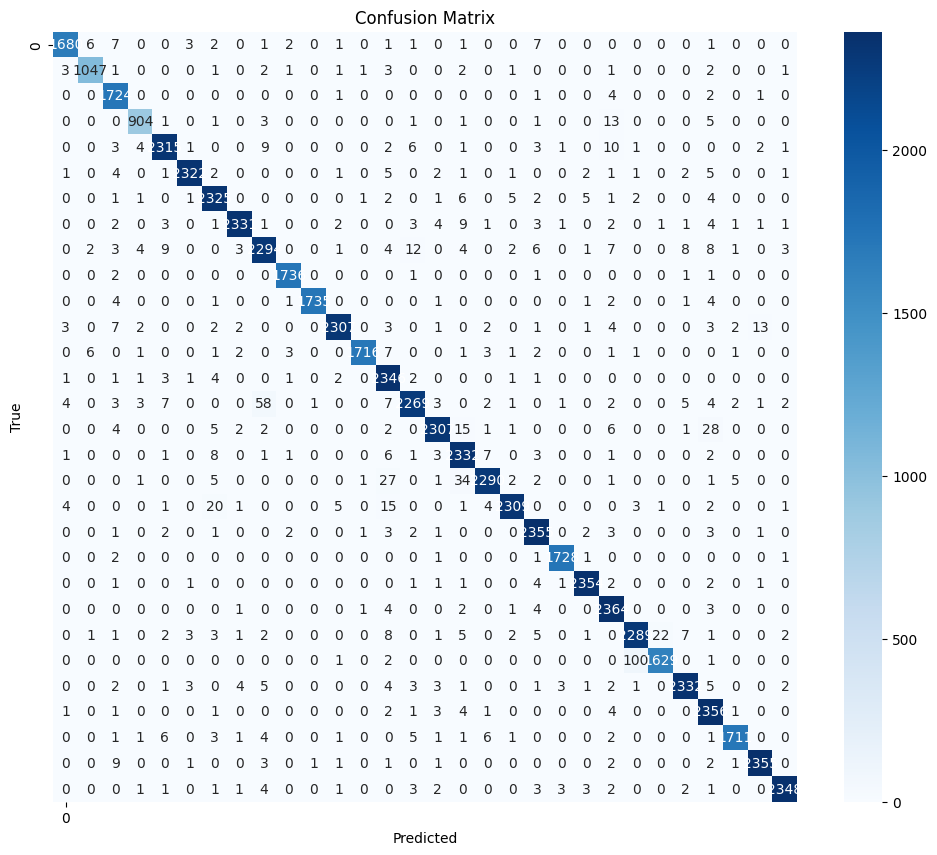

In [45]:
# Nazivi klasa
df_labels = pd.read_csv('/content/drive/MyDrive/train/data_labels.csv')
id2label = {v: k for k, v in df_labels.set_index('LabelID')['Filename'].str.extract(r'/(\w+)/')[0].dropna().astype(str).drop_duplicates().reset_index(drop=True).to_dict().items()}

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [46]:
torch.save(model.state_dict(), 'audio_cnn_model.pth')
